In [1]:
import torchvision
import os
from transformers import AutoFeatureExtractor

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # считывание изображения и ожидаемого ответа (лейбл или target) в формат COCO
        img, target = super(CocoDetection, self).__getitem__(idx)

        # обработать изображение и таргет (привести target к формату DETR,
        # изменить размер, нормализовать)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # удалить размер batch
        target = encoding["labels"][0] # удалить размер batch

        return pixel_values, target

In [2]:
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

train_dataset = CocoDetection(img_folder='dataset/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder='dataset/valid', feature_extractor=feature_extractor)

2024-04-26 21:28:46.385567: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 21:28:46.412343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 21:28:46.851327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/student1/miniconda3/envs/conda-env/lib/python3.9/site-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImagePr

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [3]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 600
Number of validation examples: 40


Image: 499


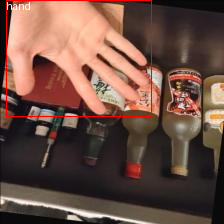

In [4]:
import numpy as np
import os
from PIL import Image, ImageDraw

# используя
# https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()

image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image: {}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('dataset/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [5]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

In [6]:
batch.keys()

dict_keys(['pixel_values', 'labels'])

In [7]:
pixel_values, target = train_dataset[0]
pixel_values.shape

torch.Size([3, 224, 224])

In [8]:
print(target)

{'size': tensor([224, 224]), 'image_id': tensor([0]), 'class_labels': tensor([2]), 'boxes': tensor([[0.4967, 0.3951, 0.6897, 0.4152]]), 'area': tensor([14368.5000]), 'iscrowd': tensor([0]), 'orig_size': tensor([224, 224])}


In [9]:
import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, weight_decay):
         super().__init__()

         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [10]:
model = Detr(lr=2.5e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'])

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([6, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from pytorch_lightning import Trainer

trainer = Trainer(accelerator='auto', max_steps=8000, gradient_clip_val=0.1, accumulate_grad_batches=4)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.607   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/student1/miniconda3/envs/conda-env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/student1/miniconda3/envs/conda-env/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/student1/miniconda3/envs/conda-env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=8000` reached.


In [13]:
%cd detr

/home/student1/PatternsDetection/Var22/object_detection/detr


In [14]:
from detr.datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset)

In [15]:
from detr.datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

Detr(
  (model): YolosForObjectDetection(
    (vit): YolosModel(
      (embeddings): YolosEmbeddings(
        (patch_embeddings): YolosPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (interpolation): InterpolateInitialPositionEmbeddings()
      )
      (encoder): YolosEncoder(
        (layer): ModuleList(
          (0-11): 12 x YolosLayer(
            (attention): YolosAttention(
              (attention): YolosSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): YolosSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropo

In [16]:
%cd ..
!jupyter nbextension enable --py widgetsnbextension

/home/student1/PatternsDetection/Var22/object_detection
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


/home/student1/miniconda3/envs/conda-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [17]:
print("Запуск оценки...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    outputs = model.model(pixel_values=pixel_values)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes)
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Запуск оценки...


  0%|          | 0/40 [00:00<?, ?it/s]

`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.


Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.893
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [25]:
test_dataset = CocoDetection(img_folder='dataset/test', feature_extractor=feature_extractor)
pixel_values, target = test_dataset[1]
pixel_values = pixel_values.unsqueeze(0).to(device)
outputs = model(pixel_values=pixel_values)
print(pixel_values.shape)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
torch.Size([1, 3, 224, 224])


In [19]:
import torch
import matplotlib.pyplot as plt

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=0.9):
  # визуализировать рамки для предсказаний, которые выше порогового значения
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  # конветировать рамки предсказаний для конкретного изображения
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  plot_results(image, probas[keep], bboxes_scaled)

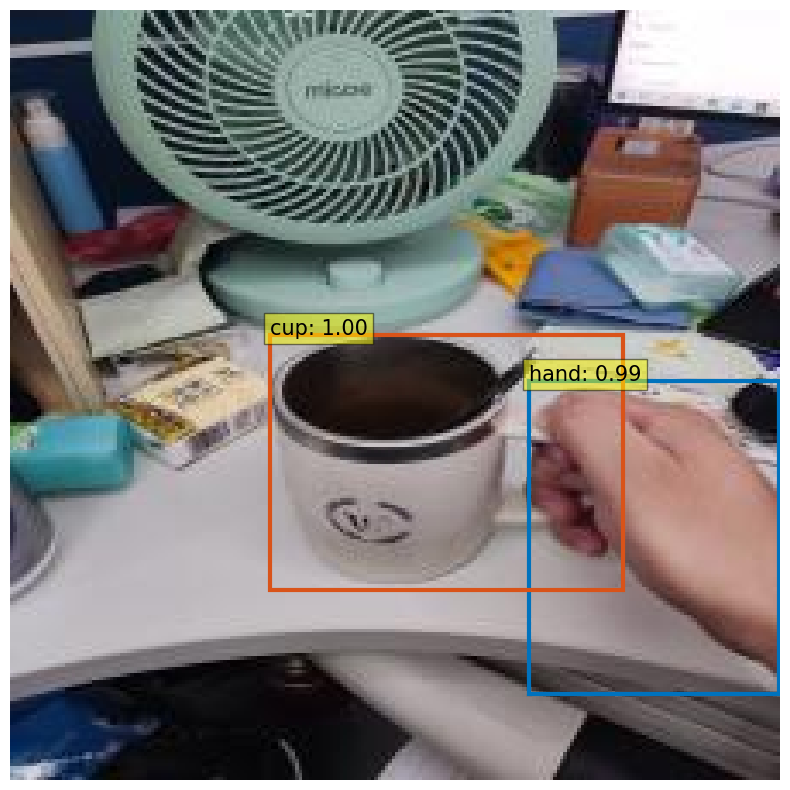

In [26]:
image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('dataset/test', image['file_name']))

visualize_predictions(image, outputs, threshold=0.5)